# Gesture Recognition
In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio
from skimage.transform import resize, rescale
from PIL import Image
import datetime
import abc as abstract
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.applications import mobilenet

#### Plotting function

In [5]:
# function to plot the training(accuracy/loss) and validation(accuracy/loss) .

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
project_folder = "/home/datasets/Project_data"

In [7]:
class ModelBuilder(metaclass= abstract.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self, source_path, folder_list, augment = False):
        #print( 'Source path = ', source_path, '; batch size =', batch_size)
        total_frames = self.total_frames
        num_images = self.frames_to_sample
        batch_size = self.batch_size
        height = self.image_height
        width = self.image_width
        
        datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, 
                                     width_shift_range=0.1, height_shift_range=0.1, 
                                     zoom_range=0.2, rotation_range=20) if augment else None
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size # calculate the number of batches
            img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

            for batch in range(num_batches): # we iterate over the number of batches
                batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                        image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes                    
                        h, w, c = image.shape
                        image = resize(image, (height, width), anti_aliasing=True)

                        # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                        if augment:
                            if np.random.randn() > 0:
                                image = datagen.random_transform(image)                   

                        batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            # write the code for the remaining data points which are left after full batches
            if (len(t)%batch_size):
                remaining_batch_size = len(t)%batch_size
                batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
                batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

                for folder in range(remaining_batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        h, w, c = image.shape
                        image = resize(image, (height, width), anti_aliasing=True)                          

                        # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                        if augment:
                            if np.random.randn() > 0:
                                image = datagen.random_transform(image)                   

                        batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

                yield batch_data, batch_labels
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        # write the REducelronplateau code here
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abstract.abstractmethod
    def define_model(self):
        pass

### Sanity testing of Generator


Pixel values range: 0.0 to 1.0


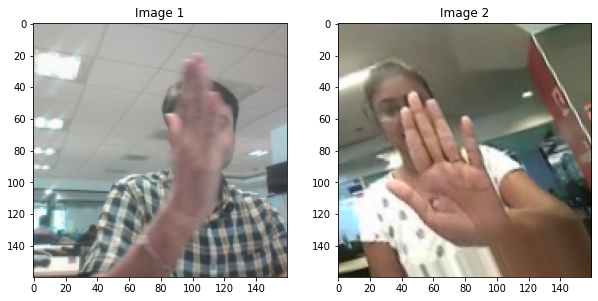

In [9]:
class Test(ModelBuilder):
    def define_model(self):
        pass

test_generator = Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160, image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3, num_epochs=1)

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)
batch_data, batch_labels = next(g)

# Check the range of pixel values in batch_data
print(f"Pixel values range: {batch_data.min()} to {batch_data.max()}")

# Visualize images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Original image
axes[0].imshow((batch_data[0, 28, :, :, :] * 255).astype(np.uint8))
axes[0].set_title('Image 1')
axes[1].imshow((batch_data[1, 29, :, :, :] * 255).astype(np.uint8))
axes[1].set_title('Image 2')

plt.show()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1

#### Conv 3D Model with
+ 20 frames per video 
+  3 by 3 filter size  (16, 32, 64, 128 conv 3D layers )
+  64 dense layer 
+  image size 160 by 160
+ batch_size=40
+ num_epochs=20

In [11]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.01)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=20)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

2024-05-29 08:05:52.449394: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-29 08:05:52.449482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [12]:
history_model1 = conv_3d1.train_model(conv_3d1_model)

Epoch 1/20


2024-05-28 21:08:43.515037: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.7885 - categorical_accuracy: 0.3469
Epoch 00001: saving model to model_init_2024-05-2821_08_35.673404/model-00001-1.78845-0.34691-599.19275-0.23000.h5
17/17 [==============================] - 120s 7s/step - loss: 1.7885 - categorical_accuracy: 0.3469 - val_loss: 599.1927 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.3565 - categorical_accuracy: 0.3952
Epoch 00002: saving model to model_init_2024-05-2821_08_35.673404/model-00002-1.35648-0.39517-198.57288-0.18000.h5
17/17 [==============================] - 117s 7s/step - loss: 1.3565 - categorical_accuracy: 0.3952 - val_loss: 198.5729 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.1230 - categorical_accuracy: 0.5113
Epoch 00003: saving model to model_init_2024-05-2821_08_35.673404/model-00003-1.12300-0.51131-45.42344-0.21000.h5
17/17 [====

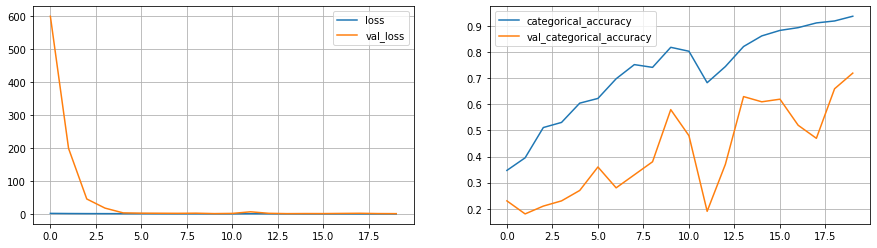

In [13]:
plot(history_model1)

#### Observation:

##### Overfitting
The training loss is quite low and accuracy is high, but the validation loss is high, and the validation accuracy is quite low (0.2000). 
Hence, model might be overfitting to the training data.

## Model 2

#### Conv 3D Model with
+ 20 frames per video 
+  3 by 3 filter size  (16, 32, 64, 128 conv 3D layers )
+  256 dense layer 
+  image size 160 by 160
+ batch_size=20
+ num_epochs=25
+ dropout = 0.5

In [12]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

2024-06-04 08:33:18.484596: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-04 08:33:18.484654: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-04 08:33:18.484688: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

In [16]:
model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Epoch 1/20


2024-05-29 02:47:41.087626: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 2.2485 - categorical_accuracy: 0.2866
Epoch 00001: saving model to model_init_2024-05-2902_47_34.980811/model-00001-2.24855-0.28658-529.34680-0.23000.h5
34/34 [==============================] - 145s 4s/step - loss: 2.2485 - categorical_accuracy: 0.2866 - val_loss: 529.3468 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.8865 - categorical_accuracy: 0.3590
Epoch 00002: saving model to model_init_2024-05-2902_47_34.980811/model-00002-1.88647-0.35897-388.14606-0.20000.h5
34/34 [==============================] - 141s 4s/step - loss: 1.8865 - categorical_accuracy: 0.3590 - val_loss: 388.1461 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.6597 - categorical_accuracy: 0.3439
Epoch 00003: saving model to model_init_2024-05-2902_47_34.980811/model-00003-1.65972-0.34389-22.23243-0.27000.h5
34/34 [====

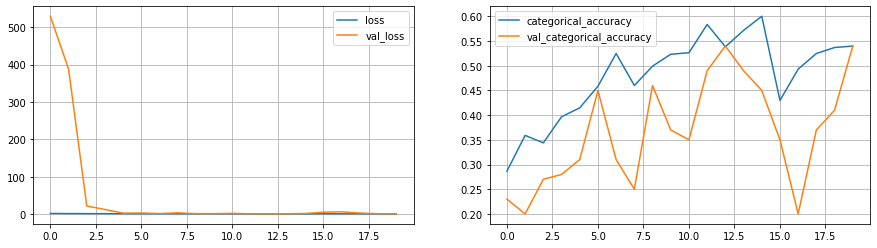

In [17]:
plot(model2)

#### Observation

#### Still Overfitting

## Model 3

#### Conv 3D Model with
+ 30 frames per video 
+  2 by 2 filter size  (16, 32, 64, 128 conv 3D layers )
+  256 dense layer 
+  image size 120 by 120
+ batch_size= 30
+ num_epochs=25
+ dropout = 0.5

In [11]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  400       
                                                                 
 activation_8 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 60, 60, 32)   

In [14]:
model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Epoch 1/25


2024-05-29 08:07:48.869461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.1610 - categorical_accuracy: 0.3092
Epoch 00001: saving model to model_init_2024-05-2908_07_39.284865/model-00001-2.16097-0.30920-1.79176-0.18000.h5
23/23 [==============================] - 197s 9s/step - loss: 2.1610 - categorical_accuracy: 0.3092 - val_loss: 1.7918 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.6091 - categorical_accuracy: 0.4223
Epoch 00002: saving model to model_init_2024-05-2908_07_39.284865/model-00002-1.60905-0.42232-2.28362-0.18000.h5
23/23 [==============================] - 194s 9s/step - loss: 1.6091 - categorical_accuracy: 0.4223 - val_loss: 2.2836 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.4927 - categorical_accuracy: 0.4827
Epoch 00003: saving model to model_init_2024-05-2908_07_39.284865/model-00003-1.49265-0.48265-2.68917-0.24000.h5
23/23 [=====

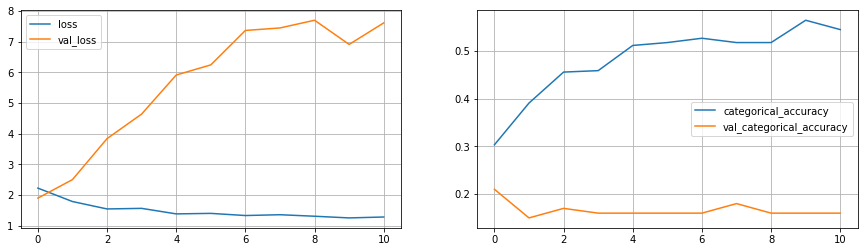

In [21]:
plot(model3)

#### Again overfitting.
All the models above have more than 1 million parameters. We will reduce the model size and check the performance

## Model 4

#### Reducing the number of parameters

#### Conv 3D Model with
+ 16 frames per video 
+  3 by 3 filter size  (16, 32, 64, 128 conv 3D layers )
+  128 dense layer 
+  image size 100 by 100
+ batch_size= 20
+ num_epochs=20
+ dropout = 0.25

In [22]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=100,image_width=100)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d4_model=conv_3d4.define_model(dense_neurons=128,dropout=0.25)
conv_3d4_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 50, 50, 32)    

In [24]:
model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.9615 - categorical_accuracy: 0.3228
Epoch 00001: saving model to model_init_2024-05-2904_50_28.730734/model-00001-1.96146-0.32278-1.74909-0.16000.h5
34/34 [==============================] - 111s 3s/step - loss: 1.9615 - categorical_accuracy: 0.3228 - val_loss: 1.7491 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.6267 - categorical_accuracy: 0.3937
Epoch 00002: saving model to model_init_2024-05-2904_50_28.730734/model-00002-1.62668-0.39367-2.33576-0.15000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.6267 - categorical_accuracy: 0.3937 - val_loss: 2.3358 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3737 - categorical_accuracy: 0.4706
Epoch 00003: saving model to model_init_2024-05-2904_50_28.730734/model-00003-1.37368-0.47059-3.08488-0.16000.h5
34

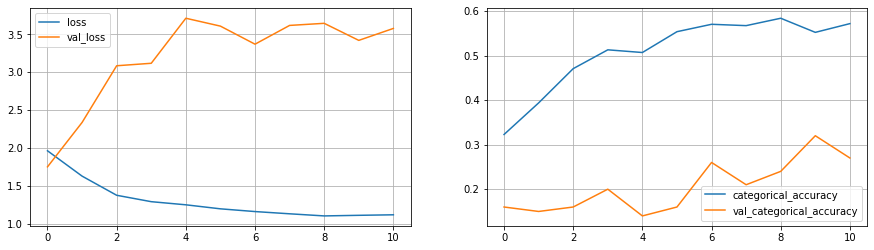

In [25]:
plot(model4)

## Model 5
#### Reducing more parameters

#### Conv 3D Model with
+ 16 frames per video 
+  3 by 3 filter size  (16, 32, 64, 128 conv 3D layers )
+  64 dense layer 
+  image size 120 by 120
+ batch_size= 20
+ num_epochs=25
+ dropout = 0.25

In [26]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d5_model=conv_3d5.define_model(dense_neurons=64,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_17 (Activation)  (None, 8, 60, 60, 32)    

In [29]:
model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8917 - categorical_accuracy: 0.3198
Epoch 00001: saving model to model_init_2024-05-2905_14_22.264192/model-00001-1.89175-0.31976-1.73061-0.21000.h5
34/34 [==============================] - 98s 3s/step - loss: 1.8917 - categorical_accuracy: 0.3198 - val_loss: 1.7306 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4635 - categorical_accuracy: 0.4314
Epoch 00002: saving model to model_init_2024-05-2905_14_22.264192/model-00002-1.46352-0.43137-1.99996-0.19000.h5
34/34 [==============================] - 96s 3s/step - loss: 1.4635 - categorical_accuracy: 0.4314 - val_loss: 2.0000 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4371 - categorical_accuracy: 0.4615
Epoch 00003: saving model to model_init_2024-05-2905_14_22.264192/model-00003-1.43707-0.46154-2.20061-0.19000.h5
34/

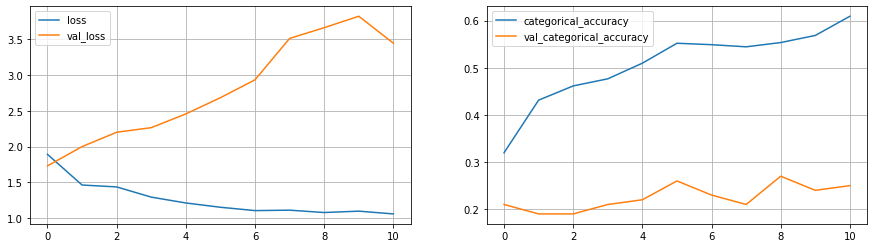

In [30]:
plot(model5)

#### Model 6

#### Conv 3D Model with
+ 20 frames per video 
+  3 by 3 filter size  (16, 32, 64, 128 conv 3D layers )
+  256,128 dense layer 
+  image size 120 by 120
+ batch_size= 20
+ num_epochs=25
+ dropout = 0.25


In [9]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=(256,128),dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons[0]))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons[1]))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=120,image_width=120)
conv_3d6.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d6_model=conv_3d6.define_model(dense_neurons=(256,128),dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_8 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 60, 60, 32)   

In [13]:
model6=conv_3d6.train_model(conv_3d6_model,augment_data=False)

Epoch 1/25


2024-06-03 16:07:18.483079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.4640 - categorical_accuracy: 0.4766
Epoch 00001: saving model to model_init_2024-06-0316_07_12.571287/model-00001-1.46396-0.47662-2.22756-0.17000.h5
34/34 [==============================] - 143s 4s/step - loss: 1.4640 - categorical_accuracy: 0.4766 - val_loss: 2.2276 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.8172 - categorical_accuracy: 0.6712
Epoch 00002: saving model to model_init_2024-06-0316_07_12.571287/model-00002-0.81721-0.67119-5.28757-0.16000.h5
34/34 [==============================] - 102s 3s/step - loss: 0.8172 - categorical_accuracy: 0.6712 - val_loss: 5.2876 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.6362 - categorical_accuracy: 0.7376
Epoch 00003: saving model to model_init_2024-06-0316_07_12.571287/model-00003-0.63619-0.73756-4.11533-0.26000.h5
34/34 [=============

## Model 7
### CNN - LSTM

#### Time distributed Conv2D with LSTM
+ 18 frames per video 
+  2 by 2 filter size  (16, 32, 64, 128 conv 3D layers )
+  64 dense layer 
+  image size 120 by 120
+ batch_size= 20
+ num_epochs= 20
+ dropout = 0.25
+ lstm_cells = 128


In [13]:
class CNN_RNN_LSTM_1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [19]:
cnn_rnn_1=CNN_RNN_LSTM_1()
cnn_rnn_1.initialize_path(project_folder)
cnn_rnn_1.initialize_image_properties(image_height=120,image_width=120)
cnn_rnn_1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
cnn_rnn_1_model=cnn_rnn_1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_rnn_1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 60, 60, 32)  

In [33]:
model6=cnn_rnn_1.train_model(cnn_rnn_1_model,augment_data=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4491 - categorical_accuracy: 0.3635
Epoch 00001: saving model to model_init_2024-05-2905_42_16.121913/model-00001-1.44911-0.36350-1.58628-0.25000.h5
34/34 [==============================] - 117s 3s/step - loss: 1.4491 - categorical_accuracy: 0.3635 - val_loss: 1.5863 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2393 - categorical_accuracy: 0.4691
Epoch 00002: saving model to model_init_2024-05-2905_42_16.121913/model-00002-1.23930-0.46908-1.68087-0.37000.h5
34/34 [==============================] - 112s 3s/step - loss: 1.2393 - categorical_accuracy: 0.4691 - val_loss: 1.6809 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1619 - categorical_accuracy: 0.5098
Epoch 00003: saving model to model_init_2024-05-2905_42_16.121913/model-00003-1.16195-0.50980-2.04796-0.29000.h5
34/34 [==

#### Model 8

##### TRANSFER LEARNING - MobileNet Conv2d + GRU
+ 20 frames per video
+ 128 dense layer
+ image size 120 by 120
+ batch_size= 10
+ num_epochs= 20
+ dropout = 0.25
+ gru_cells = 128

In [8]:
class mobilenet_RNN(ModelBuilder):
    
    def define_model(self,fine_tune=False, gru=False, lstm_cells=128, dense_neurons=128, dropout=0.25):
        
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))
        
        if (fine_tune):
        # Fine-tune from this layer onwards
            fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
            for layer in mobilenet_transfer.layers[:fine_tune_at]:
                layer.trainable = False

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        if (gru):
            model.add(GRU(lstm_cells))
        else:
            model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(self.num_classes, activation='softmax'))

        opt = Adam() #write your optimizer
        model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
        return model

In [9]:
mobinet_1=mobilenet_RNN()
mobinet_1.initialize_path(project_folder)
mobinet_1.initialize_image_properties(image_height=120,image_width=120)
mobinet_1.initialize_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=20)
mobinet_1_model=mobinet_1.define_model(fine_tune=False,gru=True)
mobinet_1_model.summary()

2024-06-03 20:41:56.986000: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-03 20:41:56.986065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Number of layers in the pretrained mobilenet model:  86
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 


Epoch 1/20


2024-06-03 20:42:10.925039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.3109 - categorical_accuracy: 0.4857
Epoch 00001: saving model to model_init_2024-06-0320_42_04.451109/model-00001-1.31089-0.48567-0.97313-0.61000.h5
67/67 [==============================] - 171s 2s/step - loss: 1.3109 - categorical_accuracy: 0.4857 - val_loss: 0.9731 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6151 - categorical_accuracy: 0.7738
Epoch 00002: saving model to model_init_2024-06-0320_42_04.451109/model-00002-0.61514-0.77376-0.57503-0.81000.h5
67/67 [==============================] - 102s 2s/step - loss: 0.6151 - categorical_accuracy: 0.7738 - val_loss: 0.5750 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4689 - categorical_accuracy: 0.8416
Epoch 00003: saving model to model_init_2024-06-0320_42_04.451109/model-00003-0.46895-0.84163-0.46197-0.84000.h5
67/67 [=============

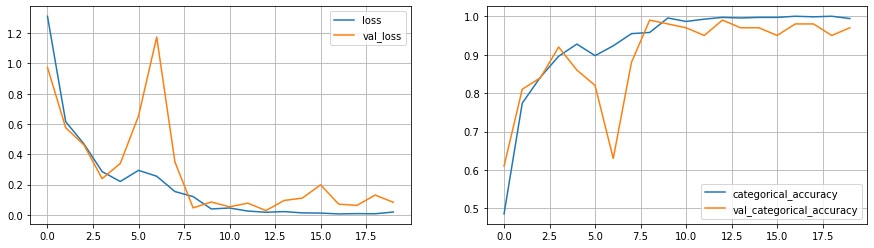

In [10]:
model_mobi=mobinet_1.train_model(mobinet_1_model,augment_data=False)
plot(model_mobi)

#### Model 9

##### MobileNet Conv2d + GRU with data augmentation
+ 30 frames per video
+ 128 dense layer
+ image size 120 by 120
+ batch_size= 10
+ num_epochs= 20
+ dropout = 0.25
+ gru_cells = 128
+ gru = true
+ data augmentation = true

In [12]:
mobinet_2=mobilenet_RNN()
mobinet_2.initialize_path(project_folder)
mobinet_2.initialize_image_properties(image_height=120,image_width=120)
mobinet_2.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=20)
mobinet_2_model=mobinet_2.define_model(fine_tune=False,gru=True)
mobinet_2_model.summary()

Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4264 - categorical_accuracy: 0.3922
Epoch 00001: saving model to model_init_2024-06-0321_28_42.893708/model-00001-1.42639-0.39216-1.41569-0.44000.h5
67/67 [==============================] - 229s 3s/step - loss: 1.4264 - categorical_accuracy: 0.3922 - val_loss: 1.4157 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.8322 - categorical_accuracy: 0.6772
Epoch 00002: saving model to model_init_2024-06-0321_28_42.893708/model-00002-0.83224-0.67722-1.02178-0.63000.h5
67/67 [==============================] - 290s 4s/step - loss: 0.8322 - categorical_accuracy: 0.6772 - val_loss: 1.0218 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.5718 - categorical_accuracy: 0.7828
Epoch 00003: saving model to model_init_2024-06-0321_28_42.893708/model-00003-0.57184-0.78281-0.46141-0.86000.h5
67/67 [==

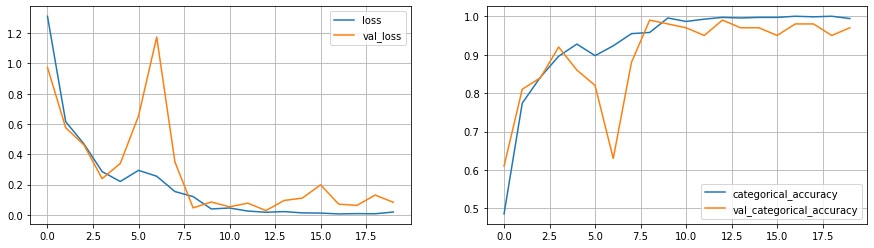

In [13]:
model_mobi_2=mobinet_2.train_model(mobinet_2_model,augment_data=True)
plot(model_mobi)

#### Model 10

##### MobileNet Conv2d + GRU with data augmentation + parameter reduction
+ 20 frames per video
+ 64 dense layer
+ image size 100 by 100
+ batch_size= 10
+ num_epochs= 20
+ dropout = 0.25
+ gru_cells = 64
+ gru = true
+ data augmentation = true
+ parameter reduction = yes

In [8]:
class mobilenet_RNN_Reduced_Param(ModelBuilder):
    
    def define_model(self, fine_tune=False, gru=False, lstm_cells=64, dense_neurons=64, dropout=0.25):
        
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(self.image_height, self.image_width, self.channels))
        print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(GlobalAveragePooling2D()))  # Using Global Pooling instead of Flatten

        if gru:
            model.add(GRU(lstm_cells))
        else:
            model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(self.num_classes, activation='softmax'))

        opt = Adam()  # Specify your optimizer
        model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
        return model

In [11]:
mobinet_reduce_1 = mobilenet_RNN_Reduced_Param()
mobinet_reduce_1.initialize_path(project_folder)
mobinet_reduce_1.initialize_image_properties(image_height=100, image_width=100)
mobinet_reduce_1.initialize_hyperparams(frames_to_sample=20, batch_size=10, num_epochs=20)
mobinet_reduce_1_model = mobinet_reduce_1.define_model(fine_tune=False, gru=True, lstm_cells=64, dense_neurons=64)
mobinet_reduce_1_model.summary()

Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)                209280    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0        

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.2652 - categorical_accuracy: 0.4510
Epoch 00001: saving model to model_init_2024-06-0420_55_38.268078/model-00001-1.26520-0.45098-1.09369-0.59000.h5
67/67 [==============================] - 115s 2s/step - loss: 1.2652 - categorical_accuracy: 0.4510 - val_loss: 1.0937 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.7066 - categorical_accuracy: 0.7255
Epoch 00002: saving model to model_init_2024-06-0420_55_38.268078/model-00002-0.70661-0.72549-0.72782-0.71000.h5
67/67 [==============================] - 111s 2s/step - loss: 0.7066 - categorical_accuracy: 0.7255 - val_loss: 0.7278 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4339 - categorical_accuracy: 0.8643
Epoch 00003: saving model to model_init_2024-06-0420_55_38.268078/model-00003-0.43386-0.86425-1.07138-0.69000.h5
67/67 [==

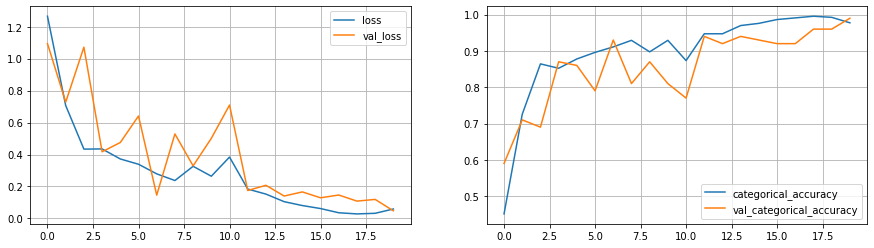

In [12]:
model_reduce_1=mobinet_reduce_1.train_model(mobinet_reduce_1_model,augment_data=True)
plot(model_reduce_1)

#### Model 11

##### MobileNet Conv2d + GRU with data augmentation + further parameter reduction

In [9]:
mobinet_2_reduce = mobilenet_RNN_Reduced_Param()
mobinet_2_reduce.initialize_path(project_folder)
mobinet_2_reduce.initialize_image_properties(image_height=100, image_width=100)
mobinet_2_reduce.initialize_hyperparams(frames_to_sample=20, batch_size=10, num_epochs=20)
mobinet_2_reduce_model = mobinet_2_reduce.define_model(fine_tune=False, gru=True, lstm_cells=16, dense_neurons=16)
mobinet_2_reduce_model.summary()

2024-06-04 20:11:00.811978: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-04 20:11:00.812042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Number of layers in the pretrained mobilenet model:  86
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 16)                50016     
                                                                 
 dropout (Dropout)           (None, 16)                0         


Epoch 1/20


2024-06-04 20:11:32.726813: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.4740 - categorical_accuracy: 0.3906
Epoch 00001: saving model to model_init_2024-06-0420_11_26.285446/model-00001-1.47398-0.39065-1.24241-0.60000.h5
67/67 [==============================] - 150s 2s/step - loss: 1.4740 - categorical_accuracy: 0.3906 - val_loss: 1.2424 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1932 - categorical_accuracy: 0.5339
Epoch 00002: saving model to model_init_2024-06-0420_11_26.285446/model-00002-1.19323-0.53394-0.92712-0.70000.h5
67/67 [==============================] - 110s 2s/step - loss: 1.1932 - categorical_accuracy: 0.5339 - val_loss: 0.9271 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9897 - categorical_accuracy: 0.6727
Epoch 00003: saving model to model_init_2024-06-0420_11_26.285446/model-00003-0.98972-0.67270-0.88806-0.70000.h5
67/67 [=============

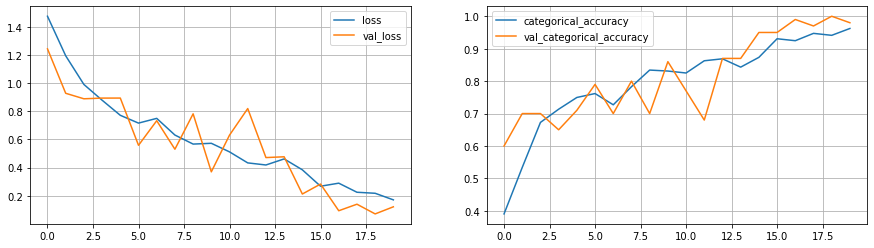

In [10]:
model_reduce=mobinet_2_reduce.train_model(mobinet_2_reduce_model,augment_data=True)
plot(model_reduce)

#### Model 12

##### MobileNet Conv2d + LSTM without data augmentation

In [10]:
mobinet_3=mobilenet_RNN()
mobinet_3.initialize_path(project_folder)
mobinet_3.initialize_image_properties(image_height=120,image_width=120)
mobinet_3.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=20)
mobinet_3_model=mobinet_3.define_model(fine_tune=False,gru=False)
mobinet_3_model.summary()

Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                

In [11]:
model_mobi_3=mobinet_3.train_model(mobinet_3_model,augment_data=False)


Epoch 1/20


2024-06-03 22:47:27.754904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.3823 - categorical_accuracy: 0.4449
Epoch 00001: saving model to model_init_2024-06-0322_47_13.008078/model-00001-1.38231-0.44495-1.33494-0.45000.h5
67/67 [==============================] - 353s 5s/step - loss: 1.3823 - categorical_accuracy: 0.4449 - val_loss: 1.3349 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9987 - categorical_accuracy: 0.5747
Epoch 00002: saving model to model_init_2024-06-0322_47_13.008078/model-00002-0.99867-0.57466-0.90413-0.63000.h5
67/67 [==============================] - 337s 5s/step - loss: 0.9987 - categorical_accuracy: 0.5747 - val_loss: 0.9041 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6969 - categorical_accuracy: 0.7345
Epoch 00003: saving model to model_init_2024-06-0322_47_13.008078/model-00003-0.69689-0.73454-0.94327-0.67000.h5
67/67 [=============

NameError: name 'model_mobi' is not defined

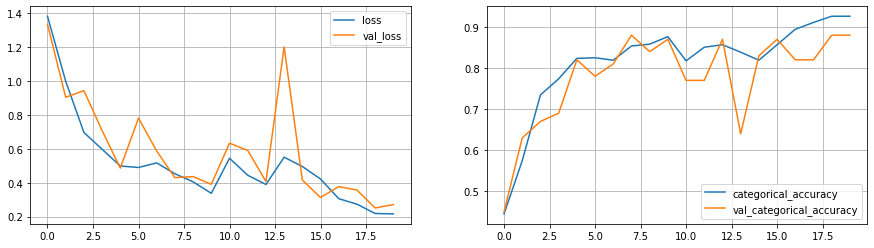

In [12]:
plot(model_mobi_3)